In [1]:
# Importações

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_auc_score,
    confusion_matrix
)

import pandas as pd
import numpy as np

from nltk.corpus import stopwords

import re

import itertools

# Cross validate

from sklearn.model_selection import cross_validate, cross_val_score

# Modelos

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

/home/ABTLUS/pedro220058/.local/lib/python3.10/site-packages/nltk/metrics/association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.stats import fisher_exact


In [2]:
# Importação do Dataframe contendo títulos de notícias relacionadas a saúde.

dataframe = pd.read_csv('dados/combined_df.zip')

display(dataframe)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Espanha reabrirá fronteiras terrestres França ...,https://noticias.uol.com.br/ultimas-noticias/a...,04/06/2020 08h27,NaN,1,o ministro turismo espanha reyes maroto anunci...
1,Rússia proíbe entrada chineses território covi...,https://noticias.uol.com.br/ultimas-noticias/a...,18/02/2020 15h08,NaN,1,o rússia anunciar hoje proibir o entrar cidadã...
2,Covid-19: 'Pandemia Brasil começou três linhag...,https://g1.globo.com/bemestar/coronavirus/noti...,13/11/2020 08h55,NaN,1,pensar trabalhar dinâmico transmissão doença i...
3,nota conjunta ministério relações exteriores m...,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,gov.br saude,1,"['nota', 'conjunta', 'ministério', 'relações',..."
4,ministério saúde vai repassar r$ 136 milhões c...,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,gov.br saude,1,"['ministério', 'saúde', 'vai', 'repassar', 'r'..."
...,...,...,...,...,...,...
5119,Associação Brasileira Infectologia (ABI) obrig...,https://www.boatos.org/saude/associacao-de-inf...,22/03/2021,NaN,0,denúncia gravar o associação brasileiro infect...
5120,maioria norte-americanos preocupada segurança ...,https://medicospelavidacovid19.com.br/noticias...,Data não disponível,Médicos Pela Vida,0,"['maioria', 'norteamericanos', 'preocupada', '..."
5121,Coronavírus: confira próximas lives música cur...,https://entretenimento.uol.com.br/noticias/red...,10/04/2020 04h00,NaN,1,apresentação artista brasileiro web o sucesso ...
5122,É enganoso Coronavac proibida EUA Europa,https://projetocomprova.com.br/publicações/e-e...,2021/05/12,NaN,0,vídeo facebook afirmar o vacinar coronavac lab...


In [3]:
# Cria dataframe para processamento
df = dataframe.copy()
df_sorted = df.sort_values(by='noticia_falsa').reset_index(drop=True)

# Transformar a coluna título em string
df_sorted['title'] = df_sorted['title'].astype(str)

In [4]:
### Filtrando notícias com valores 0 e 1
noticias_falsa_0 = df_sorted[df_sorted['noticia_falsa'] == 0]
noticias_falsa_1 = df_sorted[df_sorted['noticia_falsa'] == 1] # Aqui estão representadas as notícias verdadeiras

### Selecionar, aleatoriamente, 1000 notícias com valores 0 e 1500 com valores 1
amostra_0 = noticias_falsa_0.sample(n=1000, random_state=42)
amostra_1 = noticias_falsa_1.sample(n=1500, random_state=42)

# Criando um novo dataframe com estas notícias
novo_df = pd.concat([amostra_0, amostra_1])

# Resetando o index
novo_df = novo_df.sample(frac=1, random_state=24).reset_index(drop=True)

display(novo_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Placar mostra Pacheco frente disputa Senado,https://noticias.uol.com.br/ultimas-noticias/a...,23/01/2021 13h45,NaN,1,"Rodrigo Pacheco (DEM-MG), candidato apoiado pe..."
1,Reino Unido inicia nova abordagem teste massa ...,https://g1.globo.com/bemestar/coronavirus/noti...,03/11/2020 09h31,NaN,1,o reinar unir lançar programar pilotar teste m...
2,Publicação engana dizer pandemia declínio após...,https://projetocomprova.com.br/publicações/pub...,2020/07/23,NaN,0,site atualizados portal transparência registra...
3,Guedes defende empresários comprem vacina pede...,https://economia.uol.com.br/noticias/redacao/2...,25/03/2021 18h34,NaN,1,o ministrar economia paulo guedes defender hoj...
4,fake nóis previsão furar vidente sobrar corona...,https://www.e-farsas.com/fake-em-nois-as-previ...,14/07/2020,NaN,0,prever o futurar filmar livrar desenhar e séri...
...,...,...,...,...,...,...
2495,Bahrein segundo país aprovar vacina Pfizer/Bio...,https://noticias.uol.com.br/ultimas-noticias/a...,04/12/2020 18h14,NaN,1,O Bahrein anunciou hoje a aprovação urgente da...
2496,É #FAKE vídeo mostre Bell Marques falando novo...,https://g1.globo.com/fato-ou-fake/coronavirus/...,07/05/2020,NaN,0,circular rede social vídeo mostrar o cantor be...
2497,margareth dalcolmo,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude,1,"['margareth', 'dalcolmo', 'ministério', 'saúde..."
2498,Veja #FATO #FAKE declarações médica Nise Yamag...,https://g1.globo.com/fato-ou-fake/noticia/2021...,01/06/2021,NaN,0,o médico nise yamaguchi prestar depoimento n t...


In [5]:
# Agora, separaremos uma porção para validação com dados externos

### Separar as notícias restantes
restantes_0 = noticias_falsa_0.drop(amostra_0.index)
restantes_1 = noticias_falsa_1.drop(amostra_1.index)

# Selecionar 449 notícias restantes com valor 0 e 800 com valor 1
amostra_0_restante = restantes_0
amostra_1_restante = restantes_1.sample(n=800, random_state=42)

# Criar um novo dataframe
segundo_df = pd.concat([amostra_0_restante, amostra_1_restante])

# Bagunçar o df
segundo_df = segundo_df.sample(frac=1, random_state=48).reset_index(drop=True)

display(segundo_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,"População desocupada somou 11,8 milhões 3ª sem...",https://economia.uol.com.br/noticias/estadao-c...,10/07/2020 10h28,NaN,1,"o taxar desocupação ficar 12,3 semana o junho ..."
1,"Em meio desgaste Mandetta, Bolsonaro convida O...",https://economia.uol.com.br/colunas/carla-arau...,06/04/2020 15h09Atualizada em 06/04/2020 17h27,NaN,1,dia falar o caneta eventualmente tirar governa...
2,Anvisa cobra mudança comportamento diz vacina ...,https://noticias.uol.com.br/ultimas-noticias/a...,17/01/2021 11h41,NaN,1,o diretor-presidente agência nacional vigilânc...
3,"""Caminhão cata veio"" circula Goiânia pede idos...",https://noticias.uol.com.br/cotidiano/ultimas-...,31/03/2020 14h48,NaN,1,ação bem-humorada alertar idoso perigo sair s ...
4,"Não faltará dinheiro quiser vacinar, diz Sachsida",https://economia.uol.com.br/noticias/reuters/2...,08/01/2021 12h02,NaN,1,brasília reuters faltar dinheiro o vacinação p...
...,...,...,...,...,...,...
1239,Coronavírus: mortes suspeitas acendem alerta s...,https://noticias.uol.com.br/saude/ultimas-noti...,27/03/2020 08h58,NaN,1,familiar esperar semana respostar o testar cov...
1240,"'Saímos menos 2 mil', explica Gabbardo sobre p...",https://noticias.uol.com.br/ultimas-noticias/a...,09/08/2020 11h31,NaN,1,ex-secretário-executivo ministério saudar joão...
1241,Comediante Dave Chappelle covid-19; shows canc...,https://tvefamosos.uol.com.br/noticias/redacao...,22/01/2021 08h24,NaN,1,o comediante dave chappelle popular stand-up n...
1242,É falso número casos covid-19 menor oficial,https://projetocomprova.com.br/publicações/e-f...,2020/06/01,NaN,0,o o contrário apresentador canal youtube morte...


In [6]:
# Checar os títulos únicos em cada Dataframe

corpo_texto_novo_df = set(novo_df['corpo_texto'].unique())
corpo_texto_segundo_df = set(segundo_df['corpo_texto'].unique())

# Vendo se há títulos repetidos

corpo_texto_repetidos = corpo_texto_novo_df.intersection(corpo_texto_segundo_df)

print(f"Corpos do texto repetidos: {corpo_texto_repetidos}")

# Remover do 'segundo_df' os títulos repetidos

segundo_df_filtrado = segundo_df[~segundo_df['corpo_texto'].isin(corpo_texto_novo_df)]

segundo_df_filtrado = segundo_df_filtrado.reset_index(drop=True)

display(segundo_df_filtrado)

Corpos do texto repetidos: {"['ministério', 'saúde', 'ir', 'conteúdo', '1', 'ir', 'página', 'inicial', '2', 'ir', 'menu', 'navegação', '3', 'ir', 'busca', '4', 'ir', 'mapa', 'site', '5', 'atenção', 'navegador', 'pode', 'executar', 'javascript', 'alguns', 'recursos', 'podem', 'funcionar', 'corretamente', 'portal', 'govbr', 'acesso', 'rápido', 'acesso', 'rápido', 'órgãos', 'governo', 'acesso', 'informação', 'legislação', 'acessibilidade', 'pt', 'escolher', 'idioma', 'en', 'es', 'redefinir', 'cookies', 'mudar', 'modo', 'alto', 'contraste', 'abrir', 'menu', 'principal', 'navegação', 'ministério', 'saúde', 'termos', 'buscados', 'assinatura', 'enem', 'imposto', 'renda', 'mei', 'inss', 'termos', 'buscados', 'assinatura', 'enem', 'imposto', 'renda', 'saudebrasildoaçãodesangueconferencialivreapssapssaude', 'cienciacalendariodevacinacaoestágioretomada', 'obrasouvsusaedesaegyptiarboviroseschikungunyadenguedenguevacinacaozikaviruscoescoedenguecombateaomosquito', 'denguenasescolas', 'denguenasescol

,title,link,date,Site,noticia_falsa,corpo_texto
0,"População desocupada somou 11,8 milhões 3ª sem...",https://economia.uol.com.br/noticias/estadao-c...,10/07/2020 10h28,NaN,1,"o taxar desocupação ficar 12,3 semana o junho ..."
1,"Em meio desgaste Mandetta, Bolsonaro convida O...",https://economia.uol.com.br/colunas/carla-arau...,06/04/2020 15h09Atualizada em 06/04/2020 17h27,NaN,1,dia falar o caneta eventualmente tirar governa...
2,Anvisa cobra mudança comportamento diz vacina ...,https://noticias.uol.com.br/ultimas-noticias/a...,17/01/2021 11h41,NaN,1,o diretor-presidente agência nacional vigilânc...
3,"""Caminhão cata veio"" circula Goiânia pede idos...",https://noticias.uol.com.br/cotidiano/ultimas-...,31/03/2020 14h48,NaN,1,ação bem-humorada alertar idoso perigo sair s ...
4,"Não faltará dinheiro quiser vacinar, diz Sachsida",https://economia.uol.com.br/noticias/reuters/2...,08/01/2021 12h02,NaN,1,brasília reuters faltar dinheiro o vacinação p...
...,...,...,...,...,...,...
1212,Coronavírus: mortes suspeitas acendem alerta s...,https://noticias.uol.com.br/saude/ultimas-noti...,27/03/2020 08h58,NaN,1,familiar esperar semana respostar o testar cov...
1213,"'Saímos menos 2 mil', explica Gabbardo sobre p...",https://noticias.uol.com.br/ultimas-noticias/a...,09/08/2020 11h31,NaN,1,ex-secretário-executivo ministério saudar joão...
1214,Comediante Dave Chappelle covid-19; shows canc...,https://tvefamosos.uol.com.br/noticias/redacao...,22/01/2021 08h24,NaN,1,o comediante dave chappelle popular stand-up n...
1215,É falso número casos covid-19 menor oficial,https://projetocomprova.com.br/publicações/e-f...,2020/06/01,NaN,0,o o contrário apresentador canal youtube morte...


In [7]:
# Variáveis para padronização/configuração

scores = ['accuracy', 'precision', 'roc_auc']
usar_links = False

In [8]:
# Checar se há títulos vazios
non_empty_titles = novo_df['corpo_texto'].apply(lambda x: len(x.strip()) > 0)
non_empty_links = novo_df['link'].apply(lambda x: len(x.strip()) > 0)

# Checar o resultado
print(non_empty_titles.head())
print("Há documentos vazios?", not non_empty_titles.all())
print("Há links vazios?", not non_empty_links.all())
print("Número de documentos vazios:", (~non_empty_titles).sum())
print("Número de links vazios:", (~non_empty_links).sum())

0    True
1    True
2    True
3    True
4    True
Name: corpo_texto, dtype: bool
Há documentos vazios? False
Há links vazios? False
Número de documentos vazios: 0
Número de links vazios: 0


In [9]:
# Iniciar o processo de TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Nesta célula, será aplicado o TF-IDF aos títulos das notícias, caso não haja nenhum vazio
temp_tit = novo_df['corpo_texto'].tolist()
if non_empty_titles.all():
    titles_tfidf = tfidf_vectorizer.fit_transform(temp_tit)
    print('TF-IDF aplicado com sucesso.')
    tfidf = titles_tfidf
else:
    print('Há documentos vazios ou apenas stop words.')

TF-IDF aplicado com sucesso.


In [10]:
def split_and_clean(link):
# Dividir o link por '/', '-', '%', '.', e ':'
    words = re.split(r'[/\-\%\.\:\_]', link)
    # Remover palavras indesejadas, stopwords e letras isoladas, mantendo acentos
    unwanted = {'https', 'www', 'com', 'br', 'pt', 'html', 'htm', 'ghtml', 'php'}
    cleaned_words = [
    word for word in words
    if not any(unwanted_word in word.lower() for unwanted_word in unwanted)
    and len(word) > 1
    ]
    return cleaned_words

if usar_links:

    # Tratando os links
    df['processed_links'] = df['link'].apply(split_and_clean)

    # TF-IDF para os combinação título e link
    temp_link = [' '.join(i) for i in df['processed_links']]
    temp_tit_link = [' '.join(list(a)) for a in zip(temp_tit, temp_link)]
    print(temp_tit_link)
    if non_empty_links.all():
        tit_link_tfidf = tfidf_vectorizer.fit_transform(temp_tit_link)
        print('TF-IDF aplicado com sucesso.')
        tfidf = tit_link_tfidf
    else:
        print('Há items vazios ou apenas stop words.')

In [11]:
# Criação de vetores
X = tfidf
y = novo_df['noticia_falsa']

corpos_texto = novo_df['corpo_texto'].tolist()

print("Dimensões de X:", X.shape)
print("Dimensões de y:", y.shape)

Dimensões de X: (2500, 29053)
Dimensões de y: (2500,)


In [12]:
# Padronizando scores para todos os modelos.

scores = ['accuracy', 'precision', 'roc_auc']

### Árvore de Decisão

In [13]:
# Cria modelo
modelo_ad = DecisionTreeClassifier()
modelo_ad

# Validação cruzada
resultados_ad = cross_validate(modelo_ad, X, y, scoring=scores)

acc_ad = resultados_ad['test_accuracy'].mean()
prec_ad = resultados_ad['test_precision'].mean()
rocauc_ad = resultados_ad['test_roc_auc'].mean()
print(f'Acurácia: {acc_ad:.3f}\nPrecisão: {prec_ad:.3f}\nROC-AUC: {rocauc_ad:.3f}')

Acurácia: 0.845
Precisão: 0.870
ROC-AUC: 0.838


### Floresta Aleatória

In [14]:
# Cria modelo
modelo_rf = RandomForestClassifier()
modelo_rf

# Validação cruzada
resultados_rf = cross_validate(modelo_rf, X, y, scoring=scores)

acc_rf = resultados_rf['test_accuracy'].mean()
prec_rf = resultados_rf['test_precision'].mean()
rocauc_rf = resultados_rf['test_roc_auc'].mean()
print(f'Acurácia: {acc_rf:.3f}\nPrecisão: {prec_rf:.3f}\nROC-AUC: {rocauc_rf:.3f}')

Acurácia: 0.934
Precisão: 0.925
ROC-AUC: 0.978


### Regressão Logística

In [15]:
# Cria modelo
modelo_lr = LogisticRegression()
modelo_lr

# Validação cruzada
resultados_lr = cross_validate(modelo_lr, X, y, scoring=scores)

acc_lr = resultados_lr['test_accuracy'].mean()
prec_lr = resultados_lr['test_precision'].mean()
rocauc_lr = resultados_lr['test_roc_auc'].mean()
print(f'Acurácia: {acc_lr:.3f}\nPrecisão: {prec_lr:.3f}\nROC-AUC: {rocauc_lr:.3f}')

Acurácia: 0.921
Precisão: 0.898
ROC-AUC: 0.974


### SVC

In [16]:
# Parâmetros
C = 77
kernel = 'rbf'
gamma = 0.01

# Cria modelo
modelo_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma)

# Validação cruzada
resultados_svm = cross_validate(modelo_svm, X, y, scoring=scores)

acc_svm = resultados_svm['test_accuracy'].mean()
prec_svm = resultados_svm['test_precision'].mean()
rocauc_svm = resultados_svm['test_roc_auc'].mean()
print(f'Acurácia: {acc_svm:.3f}\nPrecisão: {prec_svm:.3f}\nROC-AUC: {rocauc_svm:.3f}')

Acurácia: 0.935
Precisão: 0.933
ROC-AUC: 0.977


### Função de comparação

In [17]:
stop_words = set(stopwords.words('portuguese'))

def trata_padrao(titulo, usar_links=False, link=None):
    '''
    Função para padronizar o tratamento dos títulos.

    Args:
    titulo (str) = título da notícia
    usar_links (bool) = usar ou não o link
    link (str) = link da notícia
    '''

    # Pré-processamento do titulo

    titulo = str(titulo).lower()
    titulo = nltk.word_tokenize(titulo)
    titulo = [word for word in titulo if word not in stop_words]
    titulo = [' '.join(titulo)]
    temp_tit = titulo

    # se usar link, pre processar link
    if usar_links:
        link = [split_and_clean(link)]
        temp_link = [' '.join(i) for i in link]
        print(temp_tit,temp_link)
        temp_tit_link = [' '.join(list(a)) for a in zip(temp_tit, temp_link)]
        processed = temp_tit_link
    else:
        processed = titulo

    return processed

In [18]:
# Define modelos para teste
modelos = [modelo_ad, modelo_rf, modelo_lr, modelo_svm]

# Treina modelos com todos os dados
for modelo in modelos:
    modelo.fit(X, y)

# Função para predizer novos títulos
def predict_title(titulo):
    preprocessed_title = trata_padrao(titulo)

    tfidf_vector = tfidf_vectorizer.transform(preprocessed_title)
    preds = dict()

    for modelo in modelos:
        preds[modelo] = modelo.predict(tfidf_vector)

    return preds

In [19]:
def comparar(df):
    '''
    Função para comparar predições de diferentes modelos com o target

    Args:
        df (pandas.df): dataframe com coluna '1' sendo os títulos/corpus, e '2' com o target/label
        
    Returns:
        list: Uma lista contendo 4 listas (uma para cada modelo: Decision Tree, Random Forest, Logistic Regression, SVC)
    '''
    DT, RF, LR, SVC = [], [], [], []
    for index, row in df.iterrows():
        text = row[0]
        target = row[1]
        pred = predict_title(text)
        pred['Target'] = [target]
        
        # Guardar as previsões em suas respectivas listas
        keys = [i for i in pred.keys()]
        DT.append(pred[keys[0]][0])
        RF.append(pred[keys[1]][0])
        LR.append(pred[keys[2]][0])
        SVC.append(pred[keys[3]][0])
        
        print(f'Notícia: {text}\n')
        for i in pred:
            print("\t{}\t{}".format(i, pred[i]))
        print('-----------------------------------------------------')
        print()
        
    return [DT, RF, LR, SVC]

### Teste com dados separados pra validação

In [20]:
segundo_df_filtrado = segundo_df_filtrado[['corpo_texto', 'noticia_falsa']]

#segundo_df.columns = ['', '']

display(segundo_df_filtrado)

,corpo_texto,noticia_falsa
0,"o taxar desocupação ficar 12,3 semana o junho ...",1
1,dia falar o caneta eventualmente tirar governa...,1
2,o diretor-presidente agência nacional vigilânc...,1
3,ação bem-humorada alertar idoso perigo sair s ...,1
4,brasília reuters faltar dinheiro o vacinação p...,1
...,...,...
1212,familiar esperar semana respostar o testar cov...,1
1213,ex-secretário-executivo ministério saudar joão...,1
1214,o comediante dave chappelle popular stand-up n...,1
1215,o o contrário apresentador canal youtube morte...,0


In [21]:
predictions = comparar(segundo_df_filtrado)

Notícia: o taxar desocupação ficar 12,3 semana o junho o pesquisar nacional amostrar domicílio contínuo covid pnad covid divulgar hoje ibge instituto brasileiro geografia e estatístico o ficar abaixar 12,4 registrar semana anterior acima semana maio 10,5 semana referência pesquisar ibge 11,8 milhão desempregar semana o junho o contingente subir 38,1 milhão levar contar o população ocupar procurar trabalhar forçar trabalhar gostar trabalhar 26,4 milhão forçar gostar trabalhar 17,3 milhão deixar buscar empregar causar pandemia covid-19 trabalhar localidade o população ocupar ficar milhão pessoa semana o junho estável comparação semana anterior indicar haver perda empregar total ocupar 13,3 11,1 milhão trabalhador afastar causar medir isolamento social relacionar covid-19 abaixar 19,8 semana maio sinalizar retornar trabalhador o atividades ocupar 8,7 milhão 12,5 total exercer atividades remotamente trabalhar casar contingente manter estável o início pnad covid

	DecisionTreeClassifier()	[

In [22]:
# Calcula score de cada método para df externo
target = segundo_df_filtrado['noticia_falsa'].tolist()

acc_dt_e = cross_val_score(modelo_ad, X, y, scoring='accuracy')
acc_rf_e = cross_val_score(modelo_rf, X, y, scoring='accuracy')
acc_lr_e = cross_val_score(modelo_lr, X, y, scoring='accuracy')
acc_svc_e = cross_val_score(modelo_svm, X, y, scoring='accuracy')

prec_dt_e = cross_val_score(modelo_ad, X, y, scoring='precision')
prec_rf_e = cross_val_score(modelo_rf, X, y, scoring='precision')
prec_lr_e = cross_val_score(modelo_lr, X, y, scoring='precision')
prec_svc_e = cross_val_score(modelo_svm, X, y, scoring='precision')

acc_dt_mean = acc_dt_e.mean()
acc_rf_mean = acc_rf_e.mean()
acc_lr_mean = acc_lr_e.mean()
acc_svc_mean = acc_svc_e.mean()

acc_dt_std = acc_dt_e.std()
acc_rf_std = acc_rf_e.std()
acc_lr_std = acc_lr_e.std()
acc_svc_std = acc_svc_e.std()

prec_dt_mean = prec_dt_e.mean()
prec_rf_mean = prec_rf_e.mean()
prec_lr_mean = prec_lr_e.mean()
prec_svc_mean = prec_svc_e.mean()

prec_dt_std = prec_dt_e.std()
prec_rf_std = prec_rf_e.std()
prec_lr_std = prec_lr_e.std()
prec_svc_std = prec_svc_e.std()

print('---- Decision Tree ----')
print(f'Acurácia: {acc_dt_mean:.3f} ± {acc_dt_std:.3f}\nPrecisão: {prec_dt_mean:.3f} ± {prec_dt_std:.3f}')
print()
print('---- Random Forest ----')
print(f'Acurácia: {acc_rf_mean:.3f} ± {acc_rf_std:.3f}\nPrecisão: {prec_rf_mean:.3f} ± {prec_rf_std:.3f}')
print()
print('---- Linear Regression ----')
print(f'Acurácia: {acc_lr_mean:.3f} ± {acc_lr_std:.3f}\nPrecisão: {prec_lr_mean:.3f} ± {acc_lr_std:.3f}')
print()
print('---- SVC ----')
print(f'Acurácia: {acc_svc_mean:.3f} ± {acc_svc_std:.3f}\nPrecisão: {prec_svc_mean:.3f} ± {acc_svc_std:.3f}')
print()

---- Decision Tree ----
Acurácia: 0.845 ± 0.010
Precisão: 0.879 ± 0.020

---- Random Forest ----
Acurácia: 0.932 ± 0.012
Precisão: 0.924 ± 0.013

---- Linear Regression ----
Acurácia: 0.921 ± 0.010
Precisão: 0.898 ± 0.010

---- SVC ----
Acurácia: 0.935 ± 0.009
Precisão: 0.933 ± 0.009



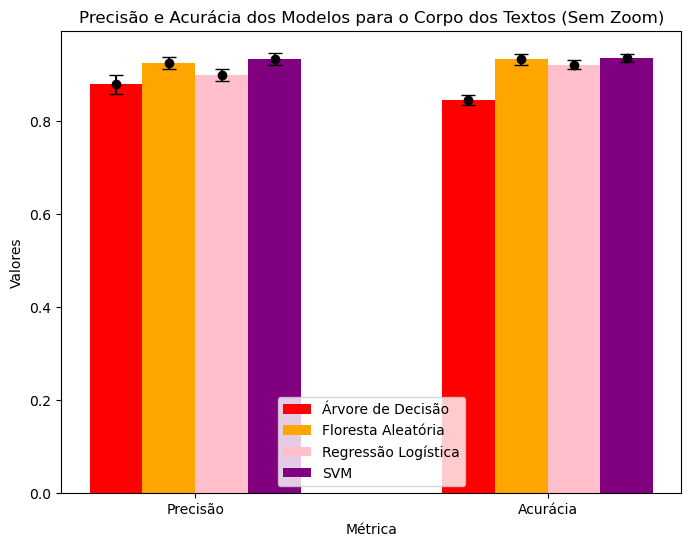

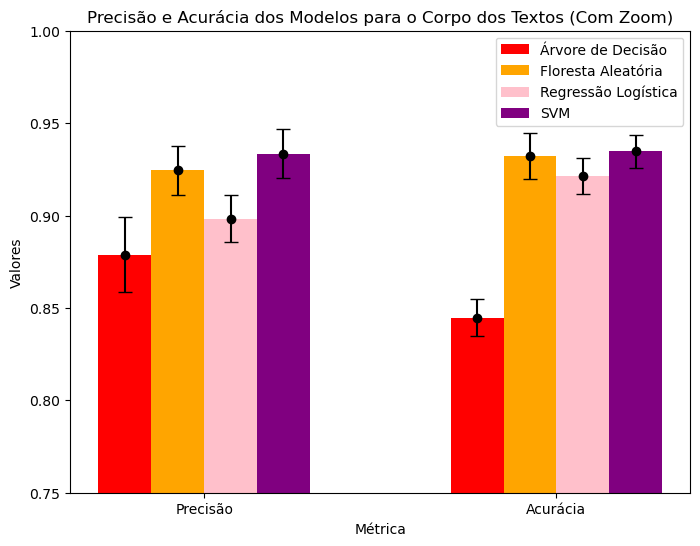

In [23]:
# Definindo os dados
accuracy_list = [acc_dt_mean, acc_rf_mean, acc_lr_mean, acc_svc_mean]
precision_list = [prec_dt_mean, prec_rf_mean, prec_lr_mean, prec_svc_mean]
acc_std_list = [acc_dt_std, acc_rf_std, acc_lr_std, acc_svc_std]
prec_std_list = [prec_dt_std, prec_rf_std, prec_lr_std, prec_svc_std]
model_labels = ['Árvore de Decisão', 'Floresta Aleatória', 'Regressão Logística', 'SVM']
colors = ['red', 'orange', 'pink', 'purple']

# Posições das barras para os grupos
x = np.arange(2)  # Um ponto para "Precisão" e outro para "Acurácia"
width = 0.15      # Largura das barras

# Criando o gráfico sem zoom
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão e Acurácia dos Modelos para o Corpo dos Textos (Sem Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia'])
ax.legend()

# Exibindo o gráfico sem zoom
plt.show()

# Criando o gráfico com zoom
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão e Acurácia dos Modelos para o Corpo dos Textos (Com Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia'])
ax.legend()

# Definindo o limite do eixo y para dar o "zoom"
plt.ylim(0.75, 1)

# Exibindo o gráfico com zoom
plt.show()